In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.model.data import __version__

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from src.base import logger
from src.config import get_config
from src.model.data import make_dataset
from src.model.features import build_features
from src.model.preprocessing import PreProcessor

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

#from xgboost import XGBClassifier


pd.options.display.max_columns = None

%config IPCompleter.use_jedi=False

In [2]:
data_config = get_config(filename="config/model.yaml")

X,y  = make_dataset(data_config, download_bases=False)


(2022-06-06 00:25:10,723)
[INFO] Download basic features

(2022-06-06 00:25:14,129)
[INFO] Download amenities features

(2022-06-06 00:25:18,438)
[INFO] Download descriptions


0        5.623249
1        5.977724
2        5.770852
3        5.698970
4        5.710083
           ...   
46379    5.505150
46380    6.447158
46382    7.294806
46383    6.352183
46384    6.204120
Name: price, Length: 45912, dtype: float64

<AxesSubplot:>

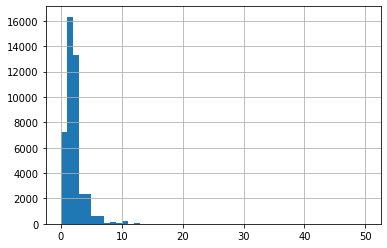

In [20]:
X['n_parking_spaces'].hist(bins=50)

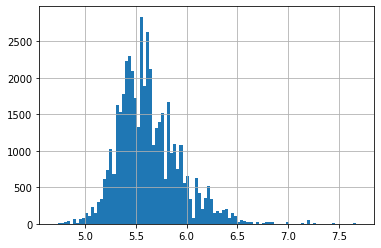

In [12]:
np.log10(y[y>0]).hist(bins=100)

plt.show()

In [8]:
data_config = get_config(filename="config/model.yaml")

features_config = get_config(filename="config/features.yaml")

X,y  = make_dataset(data_config, download_bases=False)

X,y = build_features(X, y)

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.25, random_state=42)

preprocessor = PreProcessor(features_config)

preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)

X_test = preprocessor.transform(X_test)

classifier = LogisticRegression(C=5)

classifier.fit(X_train, y_train)

classifier.predict_proba(X_test)[:,1]

accuracy_score(y_test,classifier.predict(X_test))

0.68

In [9]:
from dotenv import load_dotenv
import psycopg2
import os
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
assert load_dotenv()

engine = create_engine(
    "postgresql://{user}:{password}@{host}:{port}/{database}".format(
        user=os.getenv("DB_USERNAME"),
        password=os.getenv("DB_PASSWORD"),
        host=os.getenv("DB_HOST"),
        port=os.getenv("DB_PORT"),
        database=os.getenv("DB_NAME"),
    )
)

# amenities = pd.read_sql("""
# with tab as (
#     select *  from pocos_de_caldas.imoveis i limit 100
# )
# select search_id, jsonb_array_elements(amenities) as amenity, price from tab t
# """, engine)

# pois = pd.read_sql("""
# with tab as (
#     select *  from pocos_de_caldas.imoveis i limit 100
# )
# select search_id, jsonb_array_elements(pois_list) as pois, price from tab t
# """, engine)

In [10]:
from basix.parquet import write as to_parquet

In [10]:
df = pd.read_sql("""
    select
        id
        , search_id
        , search_date 
        , id_zap
        , type
        , jsonb_array_elements(amenities) as amenity
        , price
    from pocos_de_caldas.imoveis
""", engine)

# df['search_date'] = df['search_date'].dt.date

# to_parquet(df, "data/raw/", overwrite=True, partition_cols = ["search_date"] )



In [11]:
df

,id,search_id,search_date,id_zap,type,amenity,price
0,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,GATED_COMMUNITY,950000.0
1,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,ELEVATOR,950000.0
2,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,SERVICE_AREA,950000.0
3,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,BALCONY,950000.0
4,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,MOUNTAIN_VIEW,950000.0
...,...,...,...,...,...,...,...
132651,46392,2565495224__2022_06_04_12_51_15,2022-06-04,2565495224,HOME,KITCHEN,2250000.0
132652,46392,2565495224__2022_06_04_12_51_15,2022-06-04,2565495224,HOME,POOL,2250000.0
132653,46392,2565495224__2022_06_04_12_51_15,2022-06-04,2565495224,HOME,BACKYARD,2250000.0
132654,46392,2565495224__2022_06_04_12_51_15,2022-06-04,2565495224,HOME,SERVICE_AREA,2250000.0
